# Bayesian Optimization with XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/brian/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/brian/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Read Data
Use all data for a better score. However using around five million rows is much more manageable, and will still result in an acceptable score. The data appears to be randomized, so reading in the beginning rows is acceptable.

Using the entire dataset will use around 32gb of memory throughout this notebook, So primarily for this reason, I achieved first place on the leaderboard as of July 31,2018 using an AWS EC2 p3.2xlarge instance.

In [2]:
df = pd.read_csv('train.csv',nrows=500_000, usecols=[1,2,3,4,5,6,7])

Slicing off unecessary components of the datetime and specifying the date format results in a MUCH more efficiecnt conversion to a datetime object.

In [3]:
df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

## Clean

In [4]:
# Remove observations with missing values
# Since there are only a few of these, i'm not concerned with imputation
df.dropna(how='any', axis='rows', inplace=True)

# Removing observations with erroneous values
mask = df['pickup_longitude'].between(-75, -73)
mask &= df['dropoff_longitude'].between(-75, -73)
mask &= df['pickup_latitude'].between(40, 42)
mask &= df['dropoff_latitude'].between(40, 42)
mask &= df['passenger_count'].between(0, 8)
mask &= df['fare_amount'].between(0, 250)

df = df[mask]

## Feature Engineering
Manhattan distance provides a better approximation of actualy travelled distance than haversine for most trips.

In [5]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    
    return distance

See __[NYC Taxi Fare - Data Exploration](https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration)__ for an excellent EDA on this dataset and the intuition for including airports.

In [6]:
def transform(data):
    # Extract date attributes and then drop the pickup_datetime column
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day'] = data['pickup_datetime'].dt.day
    data['month'] = data['pickup_datetime'].dt.month
    data['year'] = data['pickup_datetime'].dt.year
    data = data.drop('pickup_datetime', axis=1)

    # Distances to nearby airports, and city center
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    nyc = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    data['distance_to_center'] = dist(nyc[1], nyc[0],
                                      data['pickup_latitude'], data['pickup_longitude'])
    data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['long_dist'] = data['pickup_longitude'] - data['dropoff_longitude']
    data['lat_dist'] = data['pickup_latitude'] - data['dropoff_latitude']
    
    data['dist'] = dist(data['pickup_latitude'], data['pickup_longitude'],
                        data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data


df = transform(df)

## Train/Test split

In [7]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

Being careful about memory management, which is critical when running the entire dataset

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('fare_amount', axis=1),
                                                    df['fare_amount'], test_size=0.25)
del(df)
dtrain = xgb.DMatrix(X_train, label=y_train)
del(X_train)
dtest = xgb.DMatrix(X_test)
del(X_test)

## Training
Optimizing hyperparameters with bayesian optimization. I've tried to limit the scope of the search as much
as possible since the search space grows exponentially when considering aditional hyperparameters.

GPU acceleration with a few pre tuned hyperparameters speeds up the search a lot.

In [9]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'objective':'gpu:reg:linear',
              'eval_metric': 'rmse',
              'tree_method':'gpu_hist',  
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}

    cv_result = xgb.cv(params, dtrain, num_boost_round = 100, early_stopping_rounds=50, nfold=5)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [10]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
xgb_bo.maximize(init_points=5, n_iter=5, acq='ei')

Initialization
----------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth | 
    1 | 00m08s |   -4.19934 |             0.6675 |    0.8228 |      3.9439 | 
    2 | 00m09s |   -3.89585 |             0.3815 |    0.2923 |      6.8738 | 
    3 | 00m06s |   -4.18214 |             0.8155 |    0.7721 |      3.1275 | 
    4 | 00m09s |   -3.89585 |             0.4023 |    0.1121 |      6.3013 | 
    5 | 00m08s |   -4.23612 |             0.4277 |    0.9380 |      3.2306 | 
    6 | 00m10s |   -4.06200 |             0.4806 |    0.6971 |      4.2952 | 
    7 | 00m09s |   -3.93477 |             0.3554 |    0.7777 |      6.7189 | 
    8 | 00m08s |   -3.93637 |             0.5745 |    0.2682 |      5.1711 | 
    9 | 00m07s |   -4.28337 |             0.3532 |    0.7343 |      3.1872 | 
   10 | 00m09s |   -3.93477 |             0.3639 |    0.5543 |      6.7066 | 
Bayesian Optimization
----------------------------

/home/brian/.local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.29354038e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   23 | 00m13s |   -3.79102 |             0.9000 |    0.6960 |      7.0000 | 
   24 | 00m16s |   -3.79252 |             0.9000 |    0.8599 |      7.0000 | 
   25 | 00m13s |   -3.85484 |             0.9000 |    1.0000 |      6.5450 | 


Extract the parameters of the best model

In [11]:
params = xgb_bo.res['max']['max_params']
params['max_depth'] = int(params['max_depth'])
params['objective'] = 'gpu:reg:linear'
params['tree_method'] = 'gpu_hist'

## Testing

In [12]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, dtrain, num_boost_round=100)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

3.717955348163032
3.2390925968459143


This model is overfitting, however this problem is alleviated with more training data.

## Feature Importance

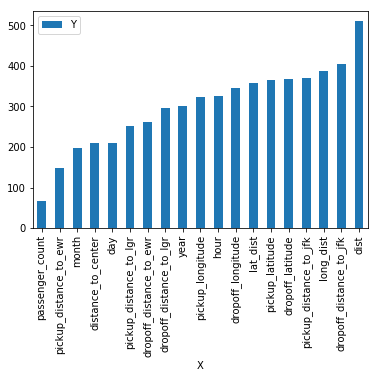

In [13]:
import matplotlib.pyplot as plt
fscores = pd.DataFrame({'X': list(model2.get_fscore().keys()), 'Y': list(model2.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

## Predict on Holdout Set

In [14]:
test = pd.read_csv('test.csv').set_index('key')
test['pickup_datetime'] = test['pickup_datetime'].str.slice(0, 16)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

# Predict on holdout set
test = transform(test)
dtest = xgb.DMatrix(test)
y_pred_test = model2.predict(dtest)

FileNotFoundError: File b'../input/test.csv' does not exist

## Submit predictions

In [ ]:
holdout = pd.DataFrame({'key': test.index, 'fare_amount': y_pred_test})
holdout.to_csv('submission.csv', index=False)